## Data Import 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv('House_Price.csv')

In [3]:
data.shape

(1460, 81)

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Feature Processing 

In [5]:
#selecting all columns that do not have numeric values
object_column = data.select_dtypes(include = ['object']).columns.tolist()

In [6]:
#selecting which columns to use one hot encoding on
#ex: Streets should use the one hot encoder because the type of road 
#access should be based on whether it exists or not. 
ohccolumn = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
             'Exterior1st','Exterior2nd', 'MasVnrType', 'Foundation','Heating','Electrical','GarageType','MiscFeature','SaleType','SaleCondition']
ohccolumn

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'Electrical',
 'GarageType',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [7]:
#selecting which columns to use label encoding on
#columns that compare the quality should be used or show that one category is better than
#another category should be used here

lccolumn = [
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence']
len(lccolumn)

18

In [8]:
#simple label encoder function
def label_encoder(data, column_name):
    
    label_encoder = preprocessing.LabelEncoder()
    data[column_name]= label_encoder.fit_transform(data[column_name])
    
    return data

In [9]:
#simple one hot encoder function
def one_hot_encoding(data, column_name):

    oh_enc = OneHotEncoder()
    oh_enc.fit(data[[column_name]])
    dummies = pd.DataFrame(oh_enc.transform(data[[column_name]]).todense(), columns=oh_enc.get_feature_names_out(), index = data.index)
    data = data.drop(column_name, axis = 1)

    return data.join(dummies)

In [10]:
for column in lccolumn:
    data = label_encoder(data, column)

In [11]:
for column in ohccolumn:
    data = one_hot_encoding(data, column)

In [12]:
data

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,3,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


<AxesSubplot:>

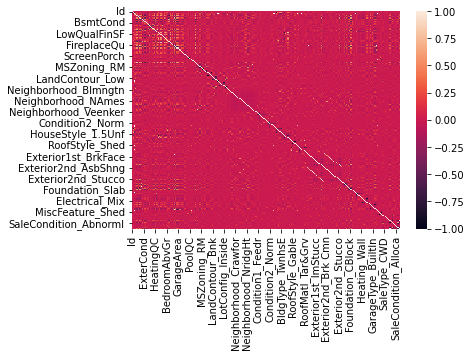

In [13]:
sns.heatmap(data.corr())

In [14]:
threshold = 0.7

df_corr = data.corr()

columns = np.full((df_corr.shape[0],), True, dtype=bool)

for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False


selected_columns = data.columns[~columns]
high_correlation = data[selected_columns]

In [15]:
absolute_corr = np.abs(df_corr["SalePrice"])
df_corr["SalePrice"][absolute_corr > 0.5]

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
ExterQual      -0.636884
BsmtQual       -0.620886
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
KitchenQual    -0.589189
TotRmsAbvGrd    0.533723
GarageFinish   -0.549247
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [16]:
selected_columns

Index(['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'SalePrice',
       'Neighborhood_Somerst', 'HouseStyle_2Story', 'RoofStyle_Shed',
       'RoofMatl_Tar&Grv', 'Exterior2nd_AsbShng', 'Exterior2nd_CBlock',
       'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_MetalSd',
       'Exterior2nd_Plywood', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd',
       'Exterior2nd_Wd Sdng', 'MiscFeature_Gar2', 'SaleCondition_Partial'],
      dtype='object')

In [17]:
high_correlation.corr()

,1stFlrSF,TotRmsAbvGrd,GarageYrBlt,GarageArea,SalePrice,Neighborhood_Somerst,HouseStyle_2Story,RoofStyle_Shed,RoofMatl_Tar&Grv,Exterior2nd_AsbShng,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MiscFeature_Gar2,SaleCondition_Partial
1stFlrSF,1.000000,0.409516,0.233449,0.489782,0.605852,-0.018495,-0.269813,0.017622,0.071021,-0.063332,-0.021856,0.080482,-0.039553,-0.144566,0.110230,0.014831,0.071504,-0.057258,-0.000300,0.221037
TotRmsAbvGrd,0.409516,1.000000,0.148112,0.337822,0.533723,-0.015275,0.430930,0.033786,-0.013142,0.002335,-0.008343,0.048695,-0.035270,-0.113001,-0.029205,0.049522,0.127698,-0.046896,0.045183,0.142032
GarageYrBlt,0.233449,0.148112,1.000000,0.564567,0.486362,0.277452,0.186831,-0.000782,-0.050926,-0.136388,-0.012559,0.113738,-0.047607,-0.198319,-0.055669,-0.136639,0.533014,-0.325996,-0.015451,0.349327
GarageArea,0.489782,0.337822,0.564567,1.000000,0.623431,0.184533,0.137946,0.020798,-0.006663,-0.092541,-0.016534,0.046189,-0.033155,-0.115115,-0.002738,0.001273,0.280274,-0.176492,-0.003896,0.294714
SalePrice,0.605852,0.533723,0.486362,0.623431,1.000000,0.140058,0.242880,0.020557,0.004921,-0.099220,-0.025028,0.128183,-0.067864,-0.162389,-0.052941,-0.042416,0.306389,-0.161800,-0.004744,0.352060
Neighborhood_Somerst,-0.018495,-0.015275,0.277452,0.184533,0.140058,1.000000,0.144012,-0.009266,-0.021798,-0.029484,-0.006550,0.109407,-0.101687,0.085497,-0.082119,-0.033687,0.130406,-0.098807,-0.009266,0.266552
HouseStyle_2Story,-0.269813,0.430930,0.186831,0.137946,0.242880,0.144012,1.000000,-0.024524,-0.023277,-0.026829,-0.017335,0.035321,0.020934,-0.059849,-0.091798,0.034600,0.170201,-0.126494,-0.024524,0.042015
RoofStyle_Shed,0.017622,0.033786,-0.000782,0.020798,0.020557,-0.009266,-0.024524,1.000000,-0.003227,-0.004365,-0.000970,-0.007667,-0.015054,-0.015349,0.112837,-0.004987,-0.026892,-0.014627,0.499314,-0.011333
RoofMatl_Tar&Grv,0.071021,-0.013142,-0.050926,-0.006663,0.004921,-0.021798,-0.023277,-0.003227,1.000000,-0.010268,-0.002281,-0.018037,-0.035414,-0.036109,0.158520,-0.011732,-0.063263,0.035141,-0.003227,0.001648
Exterior2nd_AsbShng,-0.063332,0.002335,-0.136388,-0.092541,-0.099220,-0.029484,-0.026829,-0.004365,-0.010268,1.000000,-0.003085,-0.024398,-0.047901,-0.048841,-0.038683,-0.015869,-0.085570,-0.046544,-0.004365,-0.036062


/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


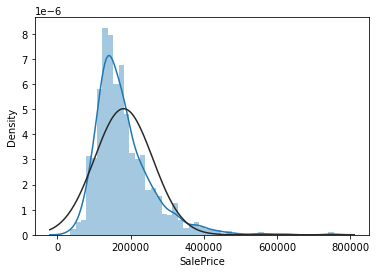

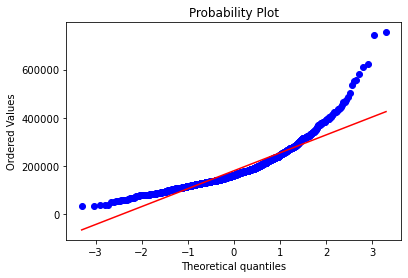

In [18]:
from scipy.stats import norm
sns.distplot(data['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)

/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


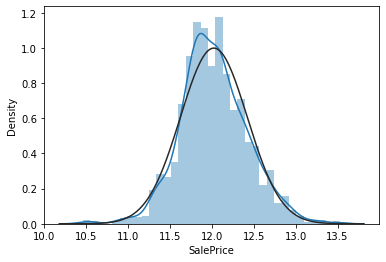

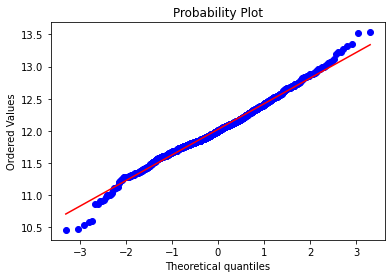

In [19]:
data['SalePrice'] = np.log(data['SalePrice'])
sns.distplot(data['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)

## Random Forest Model 

In [20]:
data = data.dropna()
X = data.drop(['SalePrice', 'Id'], axis = 'columns')
y = data['SalePrice']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train);

In [22]:
#made a dataframe with values greater than .001 importance
#sorted the values to look better on bargraph
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
a = dataframe[dataframe[0] > .001]
a = a.rename(columns = {0: 'values'})
b = a.sort_values('values', ascending = True)
b

,values
ExterCond,0.001057
Neighborhood_Crawfor,0.001090
HeatingQC,0.001346
BsmtFullBath,0.001347
MSSubClass,0.001387
SaleCondition_Family,0.001449
BedroomAbvGr,0.001509
Fireplaces,0.001571
BsmtExposure,0.001605
YrSold,0.001952


<BarContainer object of 43 artists>

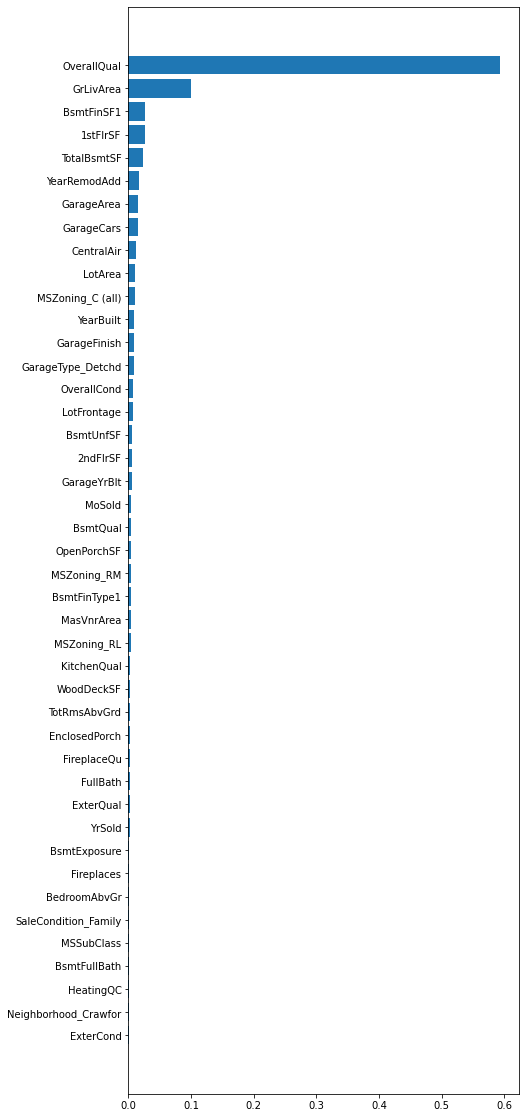

In [23]:
plt.figure(figsize=(7, 20))
plt.barh(b.index, b['values'])

In [24]:
#made another dataframe with a smaller importance threshold
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
c = dataframe[dataframe[0] > .01]
c = c.rename(columns = {0: 'values'})
d = c.sort_values('values', ascending = True)
d

,values
LotArea,0.011214
CentralAir,0.012535
GarageCars,0.014534
GarageArea,0.015550
YearRemodAdd,0.017105
TotalBsmtSF,0.023368
1stFlrSF,0.026038
BsmtFinSF1,0.026774
GrLivArea,0.099737
OverallQual,0.593658


<BarContainer object of 10 artists>

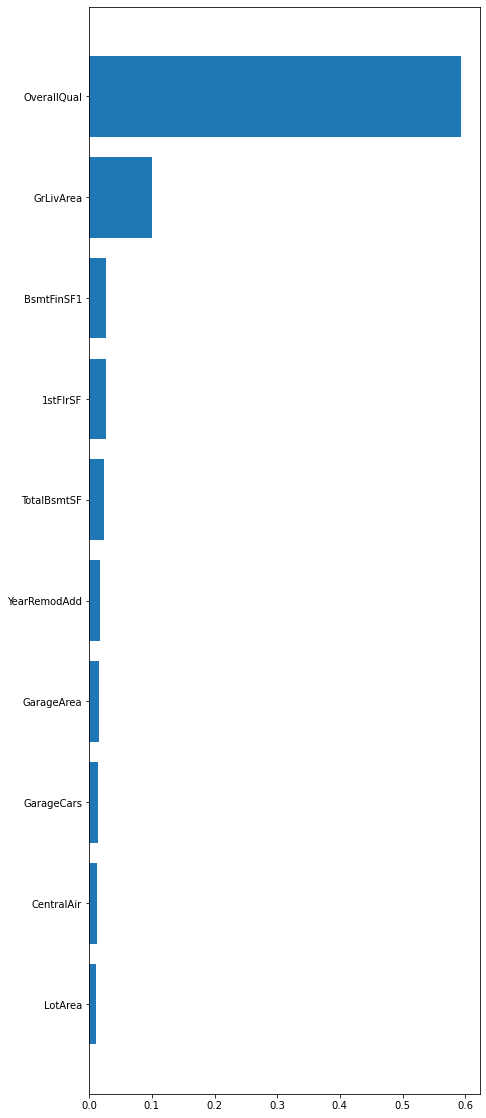

In [25]:
plt.figure(figsize=(7, 20))
plt.barh(d.index, d['values'])

## Author Contributions:

Isaac: 

Brandon:

Raj: 